In [1]:
from transformers import Trainer, TrainingArguments, DataCollatorForLanguageModeling, GPT2LMHeadModel, pipeline, \
                          GPT2Tokenizer
import pandas as pd
from datasets import Dataset

In [2]:
reviews = pd.read_csv('data/reviews.csv')[['Text', 'Summary', 'Score']]
reviews.shape

(568454, 3)

In [3]:
reviews.head()

,Text,Summary,Score
0,I have bought several of the Vitality canned d...,Good Quality Dog Food,5
1,Product arrived labeled as Jumbo Salted Peanut...,Not as Advertised,1
2,This is a confection that has been around a fe...,"""Delight"" says it all",4
3,If you are looking for the secret ingredient i...,Cough Medicine,2
4,Great taffy at a great price. There was a wid...,Great taffy,5


In [4]:
reviews['Text'].str.len().value_counts()

126     1894
135     1885
127     1860
138     1858
122     1835
        ... 
4142       1
3783       1
4003       1
4112       1
4037       1
Name: Text, Length: 3828, dtype: int64

<Axes: title={'center': 'Histogram of Review Length'}, ylabel='Frequency'>

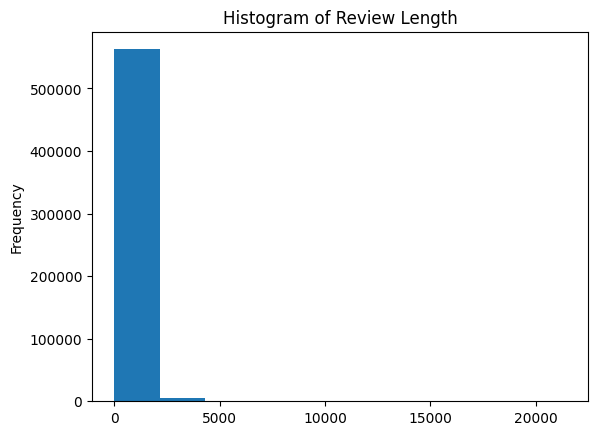

In [5]:
reviews['Text'].str.len().plot(kind='hist', title='Histogram of Review Length')

<Axes: title={'center': 'Histogram of Summary Length'}, ylabel='Frequency'>

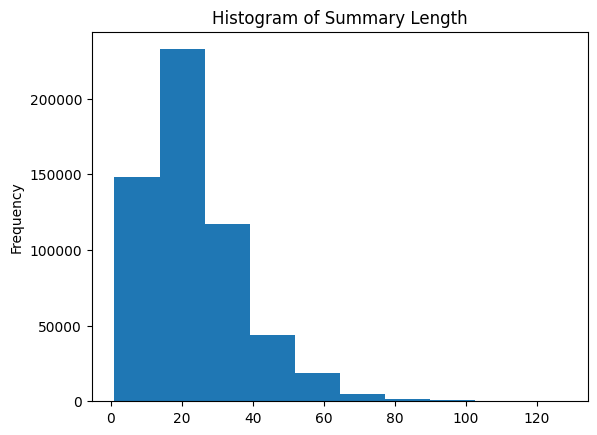

In [6]:
reviews['Summary'].str.len().plot(kind='hist', title='Histogram of Summary Length')

<Axes: title={'center': 'Histogram of Summary Length'}, ylabel='Frequency'>

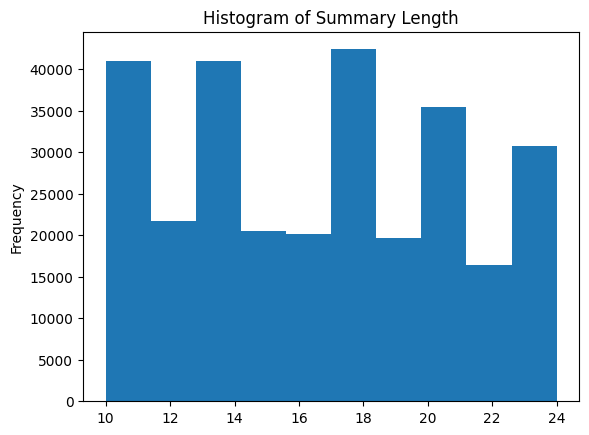

In [7]:
reviews = reviews[(reviews['Summary'].str.len() >= 10) & (reviews['Summary'].str.len() < 25)]
reviews['Summary'].str.len().plot(kind='hist', title='Histogram of Summary Length')

In [8]:
reviews['Sentiment'] = reviews['Score'].map(lambda x: 'positive' if x >= 4 else 'neutral' if x == 3 else 'negative')
reviews.head()

,Text,Summary,Score,Sentiment
0,I have bought several of the Vitality canned d...,Good Quality Dog Food,5,positive
1,Product arrived labeled as Jumbo Salted Peanut...,Not as Advertised,1,negative
2,This is a confection that has been around a fe...,"""Delight"" says it all",4,positive
3,If you are looking for the secret ingredient i...,Cough Medicine,2,negative
4,Great taffy at a great price. There was a wid...,Great taffy,5,positive


In [9]:
reviews = reviews.groupby('Sentiment', group_keys=False).apply(lambda x: x.sample(1000))

In [10]:
reviews.head()

,Text,Summary,Score,Sentiment
96677,I ordered this product on Amazon to get some o...,Walkers Crisps 6 pack,1,negative
498477,"Sorry to say, my cat refused to eat this stuff...",My Cat Hated it!,1,negative
166768,I ordered the product and had my parents send ...,Not as advertised,1,negative
129414,Pineapple Macadamia way to sweet for me! Stat...,Too sweet!,2,negative
550396,If you are looking for STRONG S/V flavor these...,Not so good.,2,negative


<Axes: >

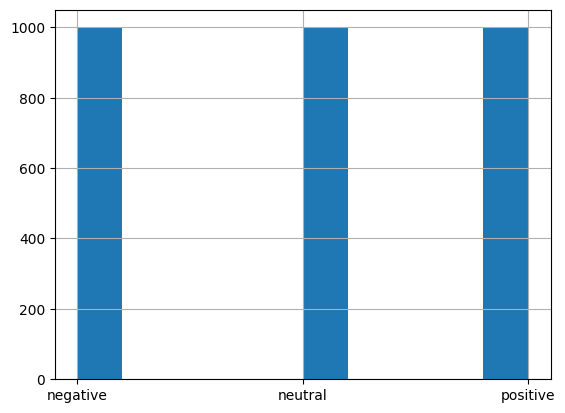

In [11]:
reviews['Sentiment'].hist()

In [12]:
MODEL = 'distilgpt2'
tokenizer = GPT2Tokenizer.from_pretrained(MODEL)
tokenizer.pad_token = tokenizer.eos_token

SENTIMENT_PROMPT = 'Sentiment Task'
SUMMARIZE_PROMPT = 'Summarize Task'
SENTIMENT_TOKEN = '\nSentiment:'
SUMMARIZE_TOKEN = '\nSummarize:'

In [13]:
reviews['sentiment_text'] = f'{SENTIMENT_PROMPT}\nReview: ' + reviews['Text'] + SENTIMENT_TOKEN + '  ' + reviews['Sentiment'].astype(str)
reviews['summarize_text'] = f'{SUMMARIZE_PROMPT}\nReview: ' + reviews['Text'] + SUMMARIZE_TOKEN + '  ' + reviews['Summary'].astype(str)
reviews.head()

,Text,Summary,Score,Sentiment,sentiment_text,summarize_text
96677,I ordered this product on Amazon to get some o...,Walkers Crisps 6 pack,1,negative,Sentiment Task\nReview: I ordered this product...,Summarize Task\nReview: I ordered this product...
498477,"Sorry to say, my cat refused to eat this stuff...",My Cat Hated it!,1,negative,"Sentiment Task\nReview: Sorry to say, my cat r...","Summarize Task\nReview: Sorry to say, my cat r..."
166768,I ordered the product and had my parents send ...,Not as advertised,1,negative,Sentiment Task\nReview: I ordered the product ...,Summarize Task\nReview: I ordered the product ...
129414,Pineapple Macadamia way to sweet for me! Stat...,Too sweet!,2,negative,Sentiment Task\nReview: Pineapple Macadamia wa...,Summarize Task\nReview: Pineapple Macadamia wa...
550396,If you are looking for STRONG S/V flavor these...,Not so good.,2,negative,Sentiment Task\nReview: If you are looking for...,Summarize Task\nReview: If you are looking for...


In [14]:
reviews['sentiment_text'].head(2).tolist()

["Sentiment Task\nReview: I ordered this product on Amazon to get some of the flavors we can't get in the US, namely, bacon, worcestershire, and prawn cocktail.  The photo of the product was so small and the description was so vague that I didn't realize until it came that what I was getting were actually 3 flavors of crisps that I can get down the street from my house:  cheddar cheese and onion, salt and vinegar, and regular flavor.  I was VERY disappointed.  Instead of trying again to order online, I will ask friends in the UK to shop and mail them for me.\nSentiment:  negative",
 "Sentiment Task\nReview: Sorry to say, my cat refused to eat this stuff. I am sure it's good but my cat wouldn't eat it.\nSentiment:  negative"]

In [15]:
reviews['summarize_text'].head(2).tolist()

["Summarize Task\nReview: I ordered this product on Amazon to get some of the flavors we can't get in the US, namely, bacon, worcestershire, and prawn cocktail.  The photo of the product was so small and the description was so vague that I didn't realize until it came that what I was getting were actually 3 flavors of crisps that I can get down the street from my house:  cheddar cheese and onion, salt and vinegar, and regular flavor.  I was VERY disappointed.  Instead of trying again to order online, I will ask friends in the UK to shop and mail them for me.\nSummarize:  Walkers Crisps 6 pack",
 "Summarize Task\nReview: Sorry to say, my cat refused to eat this stuff. I am sure it's good but my cat wouldn't eat it.\nSummarize:  My Cat Hated it!"]

In [16]:
reviews = reviews.sample(frac=1)
training_examples = reviews['summarize_text'].tolist() + reviews['sentiment_text'].tolist()
print(len(training_examples))

6000


In [17]:
training_examples

['Summarize Task\nReview: The product description does not list the ingredients so here they are:<br /><br />Ingredients: Organic Vegetables (Organic Peas, Organic Carrots), Water, Organic Ground Chicken, Organic Whole Oat Flour, Organic Split Pea Powder.\nSummarize:  Contains Chicken',
 "Summarize Task\nReview: How fortunate! I get to drink this delicious drink, it's good for me, gives me energy, makes me healthy AND I am helping save the rainforest ! I would say that is a win-win!!!\nSummarize:  Wonderful!",
 "Summarize Task\nReview: I ordered six jars of these. The taste disappointed me. Two of the jars arrived broken and I was give a refund for the two jars. I guess with the taste problems I'll try a different product.\nSummarize:  Not a great product.",
 "Summarize Task\nReview: My wife and I recently became vegetarians, some days its a little harried to get home, kick off your shoes relax a minute before you start dinner..FANTASTIC FOODS to the rescue...some days when you need he

In [18]:
multi_task_df = pd.DataFrame({'text': training_examples})
data = Dataset.from_pandas(multi_task_df)

In [19]:
def preprocess(examples):
    return tokenizer(examples['text'], truncation=True)

In [20]:
data = data.map(preprocess, batched=True)
data = data.train_test_split(train_size=.8)

Map:   0%|          | 0/6000 [00:00<?, ? examples/s]

In [21]:
model = GPT2LMHeadModel.from_pretrained(MODEL)

In [22]:
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

In [23]:
training_args = TrainingArguments(
    output_dir='gpt2_multitask',
    overwrite_output_dir=True,
    num_train_epochs=2,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    logging_steps=50,
    load_best_model_at_end=True,
    evaluation_strategy='epoch',
    save_strategy='epoch'
)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=data['train'],
    eval_dataset=data['test'],
    data_collator=data_collator
)

In [24]:
trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `GPT2LMHeadModel.forward` and have been ignored: text. If text are not expected by `GPT2LMHeadModel.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1200
  Batch size = 4
***** Running Evaluation *****
  Num examples = 1200
  Batch size = 4


{'eval_loss': 4.3167595863342285,
 'eval_runtime': 8.2699,
 'eval_samples_per_second': 145.104,
 'eval_steps_per_second': 36.276}

In [24]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `GPT2LMHeadModel.forward` and have been ignored: text. If text are not expected by `GPT2LMHeadModel.forward`,  you can safely ignore this message.
/opt/conda/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 4800
  Num Epochs = 2
  Instantaneous batch size per device = 2
  Total train batch size (w. parallel, distributed & accumulation) = 2
  Gradient Accumulation steps = 1
  Total optimization steps = 4800
  Number of trainable parameters = 81912576


Epoch,Training Loss,Validation Loss


The following columns in the evaluation set don't have a corresponding argument in `GPT2LMHeadModel.forward` and have been ignored: text. If text are not expected by `GPT2LMHeadModel.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1200
  Batch size = 2
***** Running Evaluation *****
  Num examples = 1200
  Batch size = 2
Saving model checkpoint to gpt2_multitask/checkpoint-2400
Configuration saved in gpt2_multitask/checkpoint-2400/config.json
Configuration saved in gpt2_multitask/checkpoint-2400/generation_config.json
Model weights saved in gpt2_multitask/checkpoint-2400/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `GPT2LMHeadModel.forward` and have been ignored: text. If text are not expected by `GPT2LMHeadModel.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1200
  Batch size = 2
Saving model checkpoint to gpt2_multitask/checkpoint-4800

TrainOutput(global_step=4800, training_loss=3.0358821233113606, metrics={'train_runtime': 305.6146, 'train_samples_per_second': 31.412, 'train_steps_per_second': 15.706, 'total_flos': 365145367560192.0, 'train_loss': 3.0358821233113606, 'epoch': 2.0})

In [25]:
trainer.save_model()

Saving model checkpoint to gpt2_multitask
Configuration saved in gpt2_multitask/config.json
Configuration saved in gpt2_multitask/generation_config.json
Model weights saved in gpt2_multitask/pytorch_model.bin


In [26]:
loaded_model = GPT2LMHeadModel.from_pretrained('gpt2_multitask')
generator = pipeline('text-generation', model=loaded_model, tokenizer=tokenizer)

loading configuration file gpt2_multitask/config.json
Model config GPT2Config {
  "_name_or_path": "distilgpt2",
  "_num_labels": 1,
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0
  },
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 6,
  "n_positions": 1024,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max_length": 50
    }
  },
  "torch_dtype": "flo

In [31]:
text_sample, score, summary = reviews.sample(1)[['Text', 'Sentiment', 'Summary']].values[0]
print(text_sample)
print(score)
print(summary)

num_tokens = len(tokenizer(text_sample)['input_ids'])
num_tokens

I'm eating a cup of this soup as I type this. It's handy to have in the office, it keeps me from running out to buy something deep-fried or cream-filled, and it really isn't bad. But it's not my favorite Dr. McDougall's soup. It has a slightly bitter edge that I don't care for, the kind you sometimes get from dried herbs that have been sitting too long (the use-by date is a year from now), and at the same time it seems too sweet. The first thing my wife said about it when she tried hers a few minutes ago was, "too sweet," so it's not just me (and she likes food sweeter than I do). We won't throw the rest of the box away, but I won't be ordering this one again. If I'm going to give up a trip to my favorite bakery to eat soup in my office, I want it to be better than not bad.
neutral
Not bad, not my favorite


199

In [32]:
sentiment_text_sample = f'{SENTIMENT_PROMPT}\nReview: {text_sample}{SENTIMENT_TOKEN}'
summarize_text_sample = f'{SUMMARIZE_PROMPT}\nReview: {text_sample}{SUMMARIZE_TOKEN}'

In [35]:
print(sentiment_text_sample)

Sentiment Task
Review: I'm eating a cup of this soup as I type this. It's handy to have in the office, it keeps me from running out to buy something deep-fried or cream-filled, and it really isn't bad. But it's not my favorite Dr. McDougall's soup. It has a slightly bitter edge that I don't care for, the kind you sometimes get from dried herbs that have been sitting too long (the use-by date is a year from now), and at the same time it seems too sweet. The first thing my wife said about it when she tried hers a few minutes ago was, "too sweet," so it's not just me (and she likes food sweeter than I do). We won't throw the rest of the box away, but I won't be ordering this one again. If I'm going to give up a trip to my favorite bakery to eat soup in my office, I want it to be better than not bad.
Sentiment:


In [36]:
print(summarize_text_sample)

Summarize Task
Review: I'm eating a cup of this soup as I type this. It's handy to have in the office, it keeps me from running out to buy something deep-fried or cream-filled, and it really isn't bad. But it's not my favorite Dr. McDougall's soup. It has a slightly bitter edge that I don't care for, the kind you sometimes get from dried herbs that have been sitting too long (the use-by date is a year from now), and at the same time it seems too sweet. The first thing my wife said about it when she tried hers a few minutes ago was, "too sweet," so it's not just me (and she likes food sweeter than I do). We won't throw the rest of the box away, but I won't be ordering this one again. If I'm going to give up a trip to my favorite bakery to eat soup in my office, I want it to be better than not bad.
Summarize:


In [40]:
for generated_text in generator(sentiment_text_sample, num_return_sequences=1, max_new_tokens=2):
    print(generated_text['generated_text'])

Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sentiment Task
Review: I'm eating a cup of this soup as I type this. It's handy to have in the office, it keeps me from running out to buy something deep-fried or cream-filled, and it really isn't bad. But it's not my favorite Dr. McDougall's soup. It has a slightly bitter edge that I don't care for, the kind you sometimes get from dried herbs that have been sitting too long (the use-by date is a year from now), and at the same time it seems too sweet. The first thing my wife said about it when she tried hers a few minutes ago was, "too sweet," so it's not just me (and she likes food sweeter than I do). We won't throw the rest of the box away, but I won't be ordering this one again. If I'm going to give up a trip to my favorite bakery to eat soup in my office, I want it to be better than not bad.
Sentiment:  neutral


In [47]:
for generated_text in generator(summarize_text_sample, num_return_sequences=3, max_new_tokens=20):
    print(generated_text['generated_text'])
    print('----')

Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Summarize Task
Review: I'm eating a cup of this soup as I type this. It's handy to have in the office, it keeps me from running out to buy something deep-fried or cream-filled, and it really isn't bad. But it's not my favorite Dr. McDougall's soup. It has a slightly bitter edge that I don't care for, the kind you sometimes get from dried herbs that have been sitting too long (the use-by date is a year from now), and at the same time it seems too sweet. The first thing my wife said about it when she tried hers a few minutes ago was, "too sweet," so it's not just me (and she likes food sweeter than I do). We won't throw the rest of the box away, but I won't be ordering this one again. If I'm going to give up a trip to my favorite bakery to eat soup in my office, I want it to be better than not bad.
Summarize:  Just a bit too sweet... sooooo good...  I wouldn't know as well
Sum
----
Summarize Task
Review: I'm eating a cup of this soup as I type this. It's handy to have in the office, it k

In [52]:
gpt2_generator = pipeline('text-generation', model=GPT2LMHeadModel.from_pretrained('gpt2'), tokenizer=tokenizer)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--gpt2/snapshots/e7da7f221d5bf496a48136c0cd264e630fe9fcc8/config.json
Model config GPT2Config {
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 1024,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max_length": 50
    }
  },
  "transformers_version": "4.26.1",
  "use_cach

In [53]:
for generated_text in gpt2_generator(sentiment_text_sample, num_return_sequences=5, max_new_tokens=2):
    print(generated_text['generated_text'])

Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sentiment Task
Review: I'm eating a cup of this soup as I type this. It's handy to have in the office, it keeps me from running out to buy something deep-fried or cream-filled, and it really isn't bad. But it's not my favorite Dr. McDougall's soup. It has a slightly bitter edge that I don't care for, the kind you sometimes get from dried herbs that have been sitting too long (the use-by date is a year from now), and at the same time it seems too sweet. The first thing my wife said about it when she tried hers a few minutes ago was, "too sweet," so it's not just me (and she likes food sweeter than I do). We won't throw the rest of the box away, but I won't be ordering this one again. If I'm going to give up a trip to my favorite bakery to eat soup in my office, I want it to be better than not bad.
Sentiment: This salad
Sentiment Task
Review: I'm eating a cup of this soup as I type this. It's handy to have in the office, it keeps me from running out to buy something deep-fried or cream-f

In [54]:
for generated_text in gpt2_generator(summarize_text_sample, num_return_sequences=3, max_new_tokens=20):
    print(generated_text['generated_text'])
    print('----')

Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Summarize Task
Review: I'm eating a cup of this soup as I type this. It's handy to have in the office, it keeps me from running out to buy something deep-fried or cream-filled, and it really isn't bad. But it's not my favorite Dr. McDougall's soup. It has a slightly bitter edge that I don't care for, the kind you sometimes get from dried herbs that have been sitting too long (the use-by date is a year from now), and at the same time it seems too sweet. The first thing my wife said about it when she tried hers a few minutes ago was, "too sweet," so it's not just me (and she likes food sweeter than I do). We won't throw the rest of the box away, but I won't be ordering this one again. If I'm going to give up a trip to my favorite bakery to eat soup in my office, I want it to be better than not bad.
Summarize: For a restaurant and this soup, you can have it a lot better.
----
Summarize Task
Review: I'm eating a cup of this soup as I type this. It's handy to have in the office, it keeps me